# Fairness in Decision Making

Fairness in decision making is a common problem that arises in any setting where we need to make decisions based on data. In this case, we will explore the concept of fairness in a statistical setting -- fairness is not a purely technical problem, but by leveraging basic statistical methodologies, we will see that some compelling phenomenon still arise.

Risk assessments are a very integral part of the criminal justice system. They aid judges in creating awareness of hazards and help identify who may be at risk. For example, a risk assessment that is used to inform a judge on a sentencing decisions should be able to predict whether or not a defendent is going to commit a new crime during or after their probation. Data, or information about persons with similar profiles, is a very important part of forming this risk assessment.

In the criminal justice system, there is increasing support for using algorithmic models (machine learning) in deriving risk assessments to aid judges in the decision making process - these models are built off of information about past and current defendents. Advocates argue that machine learning may lead to more efficient decisions and decrease the bias that is inherent in human judgement. Critics argue that such models perpetuate inequalities found in historical data and therefore harm historically marginalized groups of people. 

In this study, we will explore a risk assessment algorithm called the COMPAS. COMPAS examines a defendant's criminal record and other personal information to assess how likely they are to recidivate in the next two years. You can read more about the investigation carried out by ProPublica on this issue, which drew attention to the controversy of leveraging machine learning in decision making. 

We will look at the COMPAS risk score betwee whites and blacks. In addition, we will follow ProPublica's analysis and filter data where the number of days before screening is over or under 30.

In [349]:
import matplotlib.pyplot as plt 
import matplotlib.ticker
import numpy as np
import random as rd
import pandas as pd
%matplotlib inline

In [544]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas = pd.read_csv(data_url).query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')

In [545]:
compas_violent = compas[compas['race'].isin(['African-American', 'Caucasian'])].groupby(['race', 'v_decile_score'], as_index=False)
compas = compas[compas['race'].isin(['African-American', 'Caucasian'])].groupby(['race', 'decile_score'], as_index=False)


In [222]:
#for each race/decile pair, calculate stats for recidivism
def recid_count_fn(df_recid_column):
    """ Computes the total number of examples in which recidivism occurred.
        Parameters:
            df_recid_column: DataFrame column where each row takes value 1 if
            recidivism occured, and 0 if recidivism did not occur.
        Returns:
            The total number of examples in which recidivism occurred.
    """
    recid_count = df_recid_column.sum()
    return recid_count

def non_recid_count_fn(df_recid_column):
    """Computes the total number of examples in which recidivism did not occur.
    Parameters:
        df_recid_column: dataframe column where each row takes value 1 if
        recidivism occured, and 0 if recidivism did not occur.
    Returns:
        The total number of examples in which recidivism did not occur.
    """
    non_recid_count = sum(df_recid_column == 0) 
    return non_recid_count

def total_count_fn(df_recid_column):
    """Computes the total number of examples in the dataset.
    Parameters:
        df_recid_column: dataframe column where each row takes value 1 if
        recidivism occured, and 0 if recidivism did not occur.
    Returns:
        The total number of examples in the dataset.
    """
    total_count = df_recid_column.count()
    return total_count

In [223]:
compas_stats = compas['two_year_recid'].agg({'recid_count': recid_count_fn, 'non_recid_count': non_recid_count_fn, 'total_count': total_count_fn})

In [224]:
compas_violent_stats = compas_violent['two_year_recid'].agg({'recid_count': recid_count_fn, 'non_recid_count': non_recid_count_fn, 'total_count': total_count_fn})

In [227]:
#compute the classifier outcomes for different decision thresholds (using summary DataFrame above)
#often in statistics, we can express the probabilities in the introduction in terms of true positive rate, 
#true negative rate, false positive rate, and false negative rate
def TP(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take recid_count. 
    """
    TPs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] >= threshold]['recid_count'].sum()
        true_positives = x
        TPs.append(true_positives)
    return np.array(TPs, dtype=np.int32)

def FP(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of false positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take non_recid_count. 
    """
    FPs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] >= threshold]['non_recid_count'].sum()
        false_positives = x
        FPs.append(false_positives)
    return np.array(FPs, dtype=np.int32)

def TN(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true negatives for each decile_score. We classify an example as 1 if 
            that example's score less than the decision threshold. Take non_recid_count. 
    """
    TNs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] < threshold]['non_recid_count'].sum()
        true_negatives = x
        TNs.append(true_negatives)
    return np.array(TNs, dtype=np.int32)

def FN(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take recid_count. 
    """
    FNs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] < threshold]['recid_count'].sum()
        false_negatives = x
        FNs.append(false_negatives)
    return np.array(FNs, dtype=np.int32)


In [228]:
#add columns to compas stats so we can find tpr, fpr, tnr, fnr
for race in ['African-American', 'Caucasian']:
    data = compas_stats['race'] == race
    compas_stats.loc[data, 'TP'] = TP(summary[data]) 
    compas_stats.loc[data, 'TN'] = TN(compas_stats[data]) 
    compas_stats.loc[data, 'FP'] = FP(compas_stats[data]) 
    compas_stats.loc[data, 'FN'] = FN(compas_stats[data])
    compas_stats.fillna(0 , inplace=True)

In [229]:
compas_stats

,race,decile_score,recid_count,non_recid_count,total_count,TP,TN,FP,FN
0,African-American,1,85,280,365,1661.0,0.0,1514.0,0.0
1,African-American,2,105,241,346,1576.0,280.0,1234.0,85.0
2,African-American,3,125,173,298,1471.0,521.0,993.0,190.0
3,African-American,4,158,179,337,1346.0,694.0,820.0,315.0
4,African-American,5,158,165,323,1188.0,873.0,641.0,473.0
5,African-American,6,187,131,318,1030.0,1038.0,476.0,631.0
6,African-American,7,209,134,343,843.0,1169.0,345.0,818.0
7,African-American,8,215,86,301,634.0,1303.0,211.0,1027.0
8,African-American,9,229,88,317,419.0,1389.0,125.0,1242.0
9,African-American,10,190,37,227,190.0,1477.0,37.0,1471.0


# Visualization of COMPAS Risk Scores

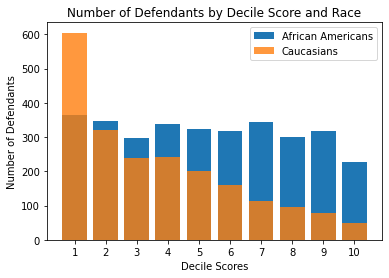

In [562]:
total = ((compas_stats['total_count'])).tolist()
percentages_african_american = total[:int(len(total)/2)]
percentages_caucasian = total[int(len(total)/2):]

decileScores = np.arange(10)
percentAfricanAmericans = plt.bar(decileScores, percentages_african_american)
percentCaucasians = plt.bar(decileScores, percentages_caucasian, alpha=0.8)

plt.ylabel('Number of Defendants')
plt.xlabel('Decile Scores')
plt.title('Number of Defendants by Decile Score and Race')
plt.xticks(decileScores, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend((percentAfricanAmericans[0], percentCaucasians[0]), ('African Americans', 'Caucasians'))
plt.show()

With 3,175 black defendants and 2,103 white defendants in the sample, we can already see that for the Caucasians group, the distribution is skewed towards lower risk decile scores.

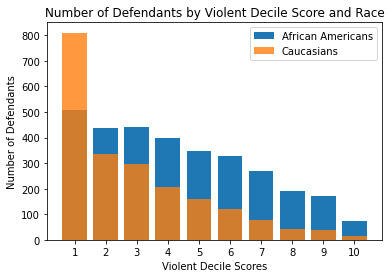

In [565]:
total_v = ((compas_violent_stats['total_count'])).tolist()
percentages_african_american = total_v[:int(len(total_v)/2)]
percentages_caucasian = total_v[int(len(total)/2):]

decileScores = np.arange(10)
percentAfricanAmericans = plt.bar(decileScores, percentages_african_american)
percentCaucasians = plt.bar(decileScores, percentages_caucasian, alpha=.8)

plt.ylabel('Number of Defendants')
plt.xlabel('Violent Decile Scores')
plt.title('Number of Defendants by Violent Decile Score and Race')
plt.xticks(decileScores, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend((percentAfricanAmericans[0], percentCaucasians[0]), ('African Americans', 'Caucasians'))
plt.show()

For the next visualization, we look at violent decile score, which indicates a rating of violence from 1 (not violent at all) to 10 (very violent). We also see a disparity in the distribution of scores for white and black defendents. We also see that for the Caucasians group, the distribution is skewed towards lower risk decile scores. But, we cannot attribute this to a difference in merely race, so we will next control for other factors and understand if there is a bias between the two racial groups.  

# Analyzing statistical criterion to ensure fairness

Although we do not have the true data of whether or not the defendent recidivated at prediction time, we can use a decision threshold. We can classify a defendent as 'will recidivate' if the decile score is greater than a threshold. Otherwise, we classify a defendent as 'will not recidivate'. We can learn the threshold that satisfies one of the statistical constraints below in an attempt to ensure fairness.

Three common statistical criteria for answering the question 'equality of what?' are:

Equalizing positive rates (in this case, the number of times we predict a defendent to recidivate given they are Caucasian is equal to the number of times we predict a defendent to recidivate given they are African American).

    P(δ(X) = 1 | A = Caucasian) = P(δ(X) = 1 | A = African American) where δ is our decision rule
    
Equalizing error rates (in this case, the proportion of times we misclassify a defendent who actually recidivated is the same for both Caucasians and African Americans, and the proportion of times we misclassify a defendent who did not actually recidivate is the same both groups). 

    P(δ(X) = 1 | Y = 0, A = Caucasian) = P(δ(X) = 1 | Y = 0, A = African American),
    P(δ(X) = 0 | Y = 1, A = Caucasian) = P(δ(X) = 0 | Y = 1, A = African American)
   
Calibration (among all defendents that get score r, on average an r proportion of them should actually be classified as positive (likely to recidivate)). 

    P(Y = 1 | R = r, A = Caucasian) = P(Y = 1 | R = r, A = African American) = r    
    
We start off by observing the outcomes of a classifier when the decision threshold occurs at each decile_score. Then, we will analyze if any of the constraints are satisfied for this decision threshold. Finally, we will compare tradeoffs of each criterion and their relevance to the investigation by ProPublica. 

# Positive Rates

In [232]:
#are they equal? compute positive rates
pr = ((compas_stats['TP'] + compas_stats['FP']) / (compas_stats['TP'] + compas_stats['FP'] + compas_stats['FN'] + compas_stats['TN']))
pr_african_americans = pr.tolist()[:int(len(compas_stats)/2)]
pr_caucasians = pr.tolist()[int(len(compas_stats)/2):]

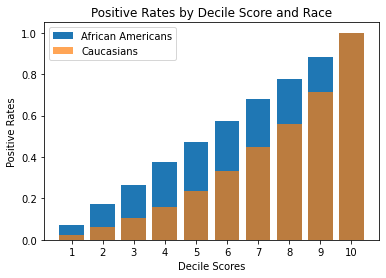

In [564]:
#visualization of equalizing pr

decileScores = np.arange(10)
prAfricanAmericans = plt.bar(decileScores, pr_african_americans[::-1])
prCaucasians = plt.bar(decileScores, pr_caucasians[::-1], alpha=.7)

plt.ylabel('Positive Rates')
plt.xlabel('Decile Scores')
plt.title('Positive Rates by Decile Score and Race')
plt.xticks(decileScores, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend((prAfricanAmericans[0], prCaucasians[0]), ('African Americans', 'Caucasians'))
plt.show()

From these visualizations, we can clearly see that the classifier does not satisfy equalizing positive rates for individual thresholds, except score decile 10. African Americans are more likely to be classified as 'high risk' than Caucasians.

But, we can still equalize positive rates by choosing two different thresholds: one for whites, one for blacks. A trivial example is the threshold for African Americans is 7 and the threshold for Caucasians is 9.

Does enforcing equal positive rates solve all issues of fairness in this situation? It turns out that one can come up
with decision rules that are undeniably unfair, as shown above, but still satisfy the criterion of equal positive rates. In this scenario, equalizing positive rates would not adequately address fairness because it is not just the number of labelings of defendents for 'high risk' that matters in the criminal justice system. 

# Error Rates

In [234]:
#are they equal? compute FPR and FNR
fpr = compas_stats['FP'] / (compas_stats['FP'] + compas_stats['TN']).tolist()
fnr = compas_stats['FN'] / (compas_stats['FN'] + compas_stats['TP']).tolist()
fpr_length = int(len(fpr)/2); fnr_length = int(len(fnr)/2)
fpr_african_americans = fpr[:fpr_length]; fpr_caucasians = fpr[fpr_length:]
fnr_african_americans = fnr[:fnr_length]; fnr_caucasians = fnr[fnr_length:]


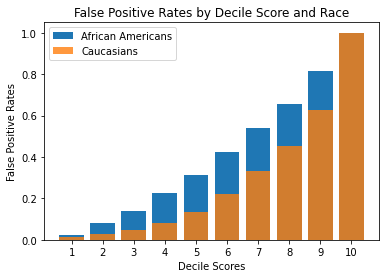

In [566]:
#visualization of equalizing FPR

decileScores = np.arange(10)
fprAfricanAmericans = plt.bar(decileScores, fpr_african_americans[::-1])
fprCaucasians = plt.bar(decileScores, fpr_caucasians[::-1], alpha=.8)

plt.ylabel('False Positive Rates')
plt.xlabel('Decile Scores')
plt.title('False Positive Rates by Decile Score and Race')
plt.xticks(decileScores, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend((fprAfricanAmericans[0], fprCaucasians[0]), ('African Americans', 'Caucasians'))
plt.show()

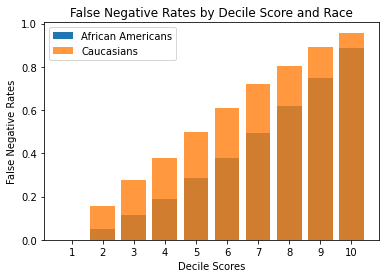

In [571]:
#visualization of equalizing FNR

decileScores = np.arange(10)

fnrAfricanAmericans = plt.bar(decileScores, fnr_african_americans)
fnrCaucasians = plt.bar(decileScores, fnr_caucasians, alpha=.8)


plt.ylabel('False Negative Rates')
plt.xlabel('Decile Scores')
plt.title('False Negative Rates by Decile Score and Race')
plt.xticks(decileScores, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend((fnrAfricanAmericans[0], fnrCaucasians[0]), ('African Americans', 'Caucasians'))
plt.show()

From these visualizations, we can clearly see that the classifier does not satisfy equalizing error rates. In particular, the first graph shows that African Americans who did not recidivate in the next two years were more likely to be misclassified as 'high risk'. The second graph shows that Caucasians who re-offended within the next two years were more likely to be mistakenly labeled as "low risk". 

But, we can choose two thresholds where error rates do equal. A common way to achieve this is by utilizing an ROC Curve. We look for the intersection of the two curves shown below. 

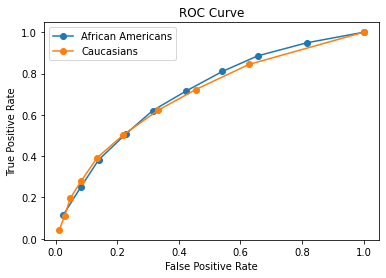

In [573]:
plt.figure()

roc_african_american = plt.plot(fpr_african_americans, 1 - np.array(fnr_african_americans), '-o', label='African Americans')
roc_caucasian = plt.plot(fpr_caucasians, 1 - np.array(fnr_caucasians), '-o', label='Caucasians')

plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend()
plt.show();


We can equalize error rates by selecting two thresholds, one for each group, such that the true positive rate and false positive rate are equal. This is true because false negative rate is just (1 - true positive rate).

Although equalizing error rates would ensure that both groups would have the same proportion of misclassifications, complex issues still arise. First, at decision time, judges don’t know who is truly a 'high risk' or 'low risk' defendent. Racial differences of defendents often strike people as unfair for risk assessments. Secondly, in order to equalize the error rates for African Americans and Caucasians, it will be necessary to make the predictions worse for one of the groups. 

Rather than worsening the predictions for some groups, it would be better to think critically about why the error rates are different between groups and try to address some of the underlying causes.

# Calibration

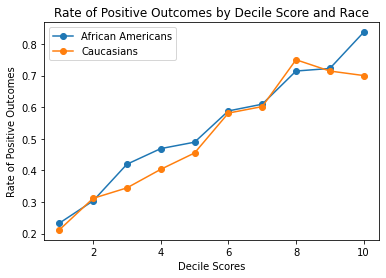

In [574]:
cal = compas_stats['recid_count'] / compas_stats['total_count']
plt.plot(np.arange(1,11), cal.tolist()[:10], '-o', label='African Americans')
plt.plot(np.arange(1,11), cal.tolist()[10:], '-o', label='Caucasians')
plt.ylabel('Rate of Positive Outcomes'); plt.xlabel('Decile Scores'); plt.title('Rate of Positive Outcomes by Decile Score and Race')
plt.legend()
plt.show();

In order to achieve calibration, we must satisfy the constraint mentioned previously, which translates to "among the defendents who recieved the same COMPAS score, a comparable percentage of black defendents reoffend in comparison to white defendents." 

The 'Rate of Positive Outcomes' is the rate at which, given a COMPAS score, defendents actually recidivate.

We can visualize this criterion by the graph above, and that is precisely what Northpointe argues the COMPAS algorithm achieves.Although the graph above does not look quite calibrated, the deviation we see in the some of the deciles may be due to the scarcity of the test data in the corresponding group and deciles. For example, the score decile of 10 has 227 defendents for African Americans and 50 defendents for Caucasians. Because we are working with a sample of what the COMPAS risk assessment actually uses, we may assume that when they say the scoring algorithm is calibrated, it may be true. 

Calibration is a fairly natural notion to consider for fairness because it is an a priori guarantee. The decision-maker sees the score R(X) = r at decision time, and knows based on this score what the frequency of positive outcomes is on average.

# Implications

It turns out that ProPublica's analysis of Northpointe’s risk assessment algorithm, COMPAS, found that black defendants were far more likely than white defendants to be misclassified as a higher risk of recidivism and white defendants were more likely to be misclassified as a lower risk of recidivism. We have shown that this statement is what equalizing error rates aims to solve, which COMPAS fails to satisfy. Interestingly, Northpointe claims that the COMPAS algorithm is fair because it satisfies the constraint of calibration. Two common non-discrimination criterion that machine learners and scientists work to satisfy when creating classification algorithms are sufficiency and separation. In this study, separation says that the classifier decisions are independent of race conditioned on the whether or not recidivism occurred. This means that for examples where recidivism actually occurred, the probability that the classifier outputs a positive decision should not differ between the races. This is precisely what equalizing error rates accomplishes, and what ProPublica argues is not accomplished by the COMPAS algorithm, and is therefore unfair. Sufficiency says that whether or not recidivism occurred is independent of race conditioned on the classifier decisions. This means that for all of the examples where the classifier outputs a positive decision, the probability of recidivism actually having occurred for those examples should not differ between the races. This is precisely what calibration accomplishes and what Northpointe achieves in the COMPAS algorithm, which they argue is fair. 

So, why not satisfy both? A collection of results known as “incompatibility results” prove that these three fairness criteria cannot occur indepdently. This means that we can only satisfy one of these criterions. If calibrate the COMPAS algorithm, then we cannot also equalize error rates [https://fairmlbook.org]. 

In conclusion, statistical fairness criteria on their own cannot be used as a “proof of fairness.” But, they can provide a starting point for thinking about issues of fairness and help surface important normative questions about decisionmaking. In this study, we unraveled the trade-offs and tensions between different potential interpretations of fairness in an attempt to find a useful solution. This study brings to light the ethical implications of delegating power to machine learning and algorithms in guiding impactful decisions, and shows that a purely technical solution to fairness is very complex and many times inadequate. In sentencing decisions and preditive policing, maybe it is best to abandon the use of learned models unless trained on non-discriminative data, evaluated by fairness experts in all relevant domains, and used in the correct scenario. 